### Import the Data

In [1365]:
import pandas as pd
import numpy as np
import pickle
import numpy as np
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
import warnings
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import diagnostic_plots
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold
import scipy
from scipy import stats
np.seterr(divide='ignore', invalid='ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore")

data = pd.read_pickle('raw_data/all_features.pkl')
df = data.loc['2017-07-08':'2018-07-08']
X = df.drop('prices',axis=1)
y_values = df.prices

## Functions you wil need

Long block of code is long. C
Future plans: 
1. Turn this into a separate file or class
2. Use the gridsearch intead of cross_val_score 
or write own kf-fold 
3. Beautify the functions
4. Include diagnostic plots as optional output
5. Set the random seed for the models by using stratified fold 

In [1366]:
def reverse_transform(y_test):       
    return np.exp(y_test+ 0.5*np.var(y_test)) - 0.5*np.var(y_test)

def print_predictions_transformation(X_train,df):
    rind = np.random.randint(0, len(X_train), size=(10,))
    predictions = model.predict(X_train)
    for index, i in enumerate(rind):
        prediction, actual = np.exp(predictions[index] + 0.5*np.var(predictions[index])), df.iloc[i,0]
        print(f"{prediction:6.4f}, {actual:6.4f}, {(prediction-actual):6.4f}")

    return None

def train_and_fit(X,y,mtype):
    # this is a messy implementation
    ss_x = StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
    X_train_scaled = ss_x.fit_transform(X_train)
    X_test_scaled = ss_x.transform(X_test)
    
    if mtype == 'Linear':
        fit = LinearRegression().fit(X_train_scaled, y_train) 
        cv = 10
    elif mtype == 'LassoCV':
        fit = LassoCV(cv=10).fit(X_train_scaled, y_train)
        cv = 10
    elif mtype == 'RidgeCV':
        fit = RidgeCV(cv=10).fit(X_train_scaled,y_train)
        cv = 10
    elif mtype == 'Polynominal':
        fit = make_pipeline(PolynomialFeatures(2), LinearRegression()).fit(X_train_scaled,y_train)
        cv = 10
    elif mtype == 'Polynominal_LassoCV':
        fit = make_pipeline(PolynomialFeatures(2), LassoCV()).fit(X_train_scaled,y_train)
        cv = 10
    elif mtype == 'Polynominal_RidgeCV':
        fit = make_pipeline(PolynomialFeatures(2), RidgeCV()).fit(X_train_scaled,y_train)
        cv = 10    
    elif mtype == 'RandomForest':
        fit=RandomForestRegressor().fit(X_train_scaled, y_train) 
        cv = 10
    elif mtype == 'DecisionTree':
        fit = DecisionTreeRegressor().fit(X_train_scaled,y_train)
        cv = 10
    else:
        print("mtype not found")
        return
     
    train = [X_train_scaled, y_train]
    test = [X_test_scaled, y_test]
    cv_scores = np.average(cross_val_score(fit, X_train_scaled, y_train, cv=cv, scoring = 'r2'))
    cv_mse = np.average(cross_val_score(fit, X_train_scaled, y_train, cv=10, scoring = 'mean_squared_error'))
    return fit, train, test, cv_scores, cv_mse 

def predict_and_plot(X_test,y_test,full_test_set_pred,transform,title):
    sns.set_style("darkgrid")
   
    fig = plt.figure(figsize = (7,5))
    sns.set_style("darkgrid",)
    if transform:
        plt.scatter(reverse_transform(full_test_set_pred), reverse_transform(y_test),alpha=.3)
        max_val = 20000
        min_val = 20000
    else:
        plt.scatter(full_test_set_pred, y_test,alpha=.3)
        max_val = 20000
        min_val = 20000
        
    plt.plot(np.linspace(0,max_val,max_val/100),np.linspace(0,max_val,max_val/100));
    plt.title(title,size = 17);
    plt.xlabel('Actual',size = 15)
    plt.ylabel('Predicted',size = 15)
    plt.xticks(size=12)
    plt.yticks(size=12)

    axes = plt.gca()
    axes.set_xlim([0,max_val])
    axes.set_ylim([0,max_val])
    savestr = 'figures/' + title + 'figure_test.svg'
    fig.savefig(savestr,dpi=300)

    return None

def feature_engineering(X):
    Xnew = X     
    Xnew['bc_tweets'] =(np.power(Xnew['tweets'],lamb)-1)/stats.boxcox_normmax(Xnew['tweets'], brack=(-1.9, 1.9))    
    Xnew['bc_transactions'] =(np.power(Xnew['transactions'],lamb)-1)/stats.boxcox_normmax(Xnew['transactions'], brack=(-1.9, 1.9))
    Xnew['bc_address'] =(np.power(Xnew['address'],lamb)-1)/stats.boxcox_normmax(Xnew['address'], brack=(-1.9, 1.9))
    Xnew['log_close'] = np.log(Xnew['close'])
    Xnew['log_world_interest'] = np.log(Xnew['worldwide_interest'])
    Xnew['log_transaction_fees'] = np.log(Xnew['transaction_fees']) 
    return Xnew.drop(['tweets',\
                 'transactions','transaction_fees','close','commits','worldwide_interest','address'],axis=1)

### Step 1) No Scaling

In [1367]:
## no feature engineering + scaling
model_types = ['Linear','LassoCV','RidgeCV','Polynominal','Polynominal_LassoCV','Polynominal_RidgeCV','DecisionTree','RandomForest']
models_dict = {}

for m in model_types:
    model, train, test, cv_score, cv_mse  = train_and_fit(X,y_values,m)
    models_dict[m] = model
    models_dict['train_data_' + m] = train
    models_dict['test_data_' + m] = test
    print(f"Model: {m}, Model Score: {model.score(train[0],train[1]):6.4f}, cross_validation: {cv_score:6.4f}, cv_mse: {reverse_transform(cv_mse):6.4f}")



Model: Linear, Model Score: 0.8871, cross_validation: 0.8700, cv_mse: 0.0000
Model: LassoCV, Model Score: 0.8871, cross_validation: 0.8700, cv_mse: 0.0000
Model: RidgeCV, Model Score: 0.8871, cross_validation: 0.8700, cv_mse: 0.0000
Model: Polynominal, Model Score: 0.9473, cross_validation: 0.9154, cv_mse: 0.0000
Model: Polynominal_LassoCV, Model Score: 0.9424, cross_validation: 0.9182, cv_mse: 0.0000
Model: Polynominal_RidgeCV, Model Score: 0.9470, cross_validation: 0.9195, cv_mse: 0.0000
Model: DecisionTree, Model Score: 1.0000, cross_validation: 0.8942, cv_mse: 0.0000
Model: RandomForest, Model Score: 0.9932, cross_validation: 0.9270, cv_mse: 0.0000


### Step 2) dep-var Scaling

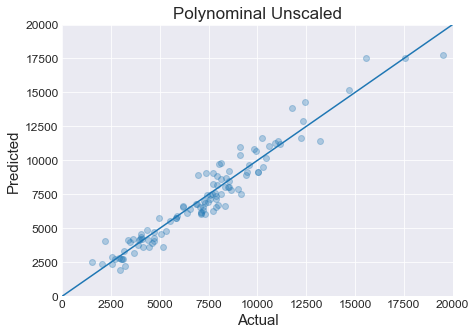

In [1368]:
best_model = models_dict['Polynominal']
testing = models_dict['test_data_Polynominal']
X_test = testing[0]
y_test = testing[1]
y_test_revtrans = y_test
full_test_set_pred = best_model.predict(X_test)
predict_and_plot(X_test,y_test,full_test_set_pred,transform = False,title='Polynominal Unscaled')

In [1369]:
plot_specific_dates(y_test,full_test_set_pred)

0.0000,11431.1000,6.4f
0.0000,11431.1000,6.4f
108.0000,9142.2800,6.4f
105.0000,17500.0000,6.4f
109.0000,7536.7200,6.4f


### Step 3) Full feature engineering (see exploratory data analysis)

In [1370]:
## scaling independent variable only + scaling
model_types = ['Linear','LassoCV','RidgeCV','Polynominal','Polynominal_LassoCV','Polynominal_RidgeCV','DecisionTree','RandomForest']

for m in model_types:
    model, train, test, cv_score, cv_mse  = train_and_fit(X,np.log(y_values),m)
    models_dict[m] = model
    models_dict['train_data_' + m] = train
    models_dict['test_data_' + m] = test
    print(f"Model: {m}, Model Score: {model.score(train[0],train[1]):6.4f}, cross_validation: {cv_score:6.4f}, cv_mse: {reverse_transform(cv_mse):6.4f}")


Model: Linear, Model Score: 0.8833, cross_validation: 0.8650, cv_mse: 0.9693
Model: LassoCV, Model Score: 0.8833, cross_validation: 0.8643, cv_mse: 0.9691
Model: RidgeCV, Model Score: 0.8822, cross_validation: 0.8666, cv_mse: 0.9694
Model: Polynominal, Model Score: 0.9410, cross_validation: 0.9059, cv_mse: 0.9785
Model: Polynominal_LassoCV, Model Score: 0.9353, cross_validation: 0.9103, cv_mse: 0.9791
Model: Polynominal_RidgeCV, Model Score: 0.9353, cross_validation: 0.9061, cv_mse: 0.9785
Model: DecisionTree, Model Score: 1.0000, cross_validation: 0.9308, cv_mse: 0.9867
Model: RandomForest, Model Score: 0.9930, cross_validation: 0.9538, cv_mse: 0.9892


In [ ]:
#### Visualization of the output and test scores

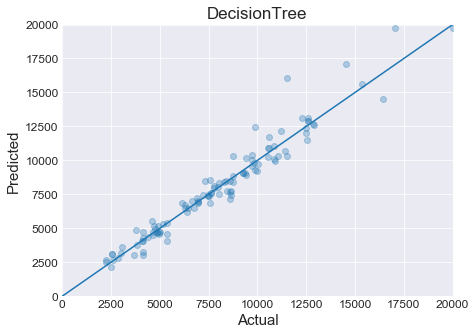

In [1371]:
best_model = models_dict['DecisionTree']
testing = models_dict['test_data_DecisionTree']
X_test = testing[0]
y_test = testing[1]
y_test_revtrans = y_test
full_test_set_pred = best_model.predict(X_test)
predict_and_plot(X_test,y_test,full_test_set_pred,transform = True,title='DecisionTree')

In [1372]:
print(best_model.score(X_test,y_test))

0.9567372599686688


In [1373]:
## feature engineering + scaling
X_trans = feature_engineering(X)
model_types = ['Linear','LassoCV','RidgeCV','Polynominal','Polynominal_LassoCV','Polynominal_RidgeCV','DecisionTree','RandomForest']
models_dict = {}

for m in model_types:
    model, train, test, cv_score, cv_mse  = train_and_fit(X_trans,np.log(y_values),m)
    models_dict[m] = model
    models_dict['train_data_' + m] = train
    models_dict['test_data_' + m] = test
    print(f"Model: {m}, Model Score: {model.score(train[0],train[1]):6.4f}, cross_validation: {cv_score:6.4f}, cv_mse: {reverse_transform(cv_mse):6.4f}")


Model: Linear, Model Score: 0.8617, cross_validation: 0.8412, cv_mse: 0.9641
Model: LassoCV, Model Score: 0.8613, cross_validation: 0.8428, cv_mse: 0.9643
Model: RidgeCV, Model Score: 0.8617, cross_validation: 0.8423, cv_mse: 0.9642
Model: Polynominal, Model Score: 0.9419, cross_validation: 0.9162, cv_mse: 0.9805
Model: Polynominal_LassoCV, Model Score: 0.9410, cross_validation: 0.9155, cv_mse: 0.9803
Model: Polynominal_RidgeCV, Model Score: 0.9416, cross_validation: 0.9179, cv_mse: 0.9808
Model: DecisionTree, Model Score: 1.0000, cross_validation: 0.9394, cv_mse: 0.9863
Model: RandomForest, Model Score: 0.9929, cross_validation: 0.9542, cv_mse: 0.9875


#### This is for the presentation. In future save as pandas df

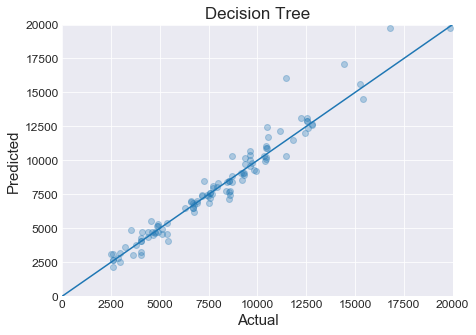

In [1375]:
best_model = models_dict['DecisionTree']
testing = models_dict['test_data_DecisionTree']
X_test = testing[0]
y_test = testing[1]
y_test_revtrans = y_test
full_test_set_pred = best_model.predict(X_test)
predict_and_plot(X_test,y_test,full_test_set_pred,transform = True,title='Decision Tree')

In [1376]:
print(best_model.score(X_test,y_test))

0.9587748205717342


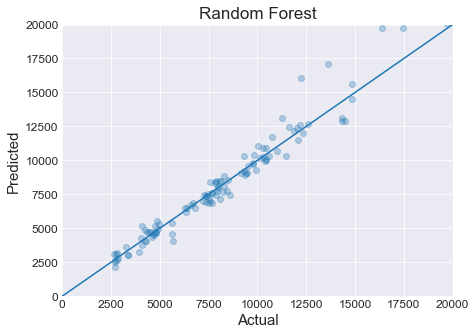

In [1377]:
# To ensure we're not overfitting, run one last prediction on the full test set
best_model = models_dict['RandomForest']
testing = models_dict['test_data_RandomForest']
X_test = testing[0]
y_test = testing[1]
y_test_revtrans = y_test
full_test_set_pred = best_model.predict(X_test)
predict_and_plot(X_test,y_test,full_test_set_pred,transform = True,title='Random Forest')

In [1378]:
print(best_model.score(X_test,y_test))

0.9657295310955711


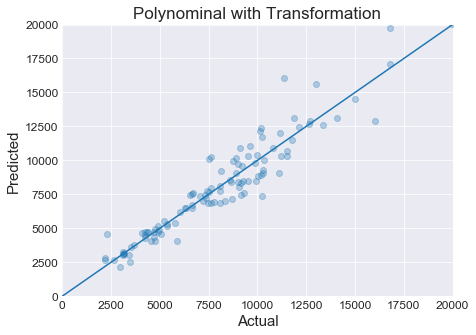

In [1379]:
# To ensure we're not overfitting, run one last prediction on the full test set

best_model = models_dict['Polynominal']
testing = models_dict['test_data_Polynominal']
X_test = testing[0]
y_test = testing[1]
y_test_revtrans = y_test
full_test_set_pred = best_model.predict(X_test)
predict_and_plot(X_test,y_test,full_test_set_pred,transform = True,title='Polynominal with Transformation')

In [1380]:
print(best_model.score(X_test,y_test))

0.9145951428050318
